In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

In [63]:
from glob import glob
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model ,Sequential
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D,MaxPooling2D, concatenate, Dense, Flatten, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [64]:
root_dir='../input/sun-segmented/mask_123'
root_polyps='../input/sun-segmented/mask_123'
root_annotations='../input/sun-polyps/annotation_csv'

In [65]:
less_more_data=pd.read_csv('../input/less-more-5/less_more.csv')
less_more_data.head()

,Less5,More5
0,3,1.0
1,4,2.0
2,5,7.0
3,6,12.0
4,9,23.0


In [ ]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

In [66]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [67]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [68]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [69]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=4

In [70]:
device

device(type='cuda')

In [71]:
img = cv2.imread('../input/sun-polyps/Polyps/Polyps/case2/case_M_20181003094031_0U62363100354631_1_001_002-1_a13_ayy_image0026.jpg')
input_batch = transform(img).to(device)
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu()


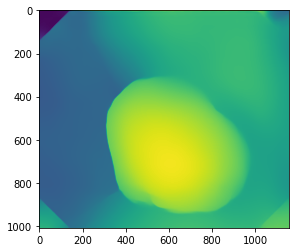

In [72]:
plt.imshow(output)

In [73]:
#Colleting less than 5 mm polyp image files
less_more_data.head()

,Less5,More5
0,3,1.0
1,4,2.0
2,5,7.0
3,6,12.0
4,9,23.0


In [74]:
polyp_dir='../input/sun-segmented/mask_123'
cases_less_5=[]
for idx in range(less_more_data.shape[0]):
    case=less_more_data[less_more_data.columns[0]][idx]
    case='case'+str(case)
    case=polyp_dir+'/'+case
    img=cv2.imread(case)
    
    cases_less_5.append(case)

In [213]:
cases_less_5[0]

'../input/sun-segmented/mask_123/case3'

In [75]:
from tqdm import tqdm

In [76]:
images_less_5=[]
for idx,x in tqdm(enumerate(cases_less_5)):
    case=cases_less_5[idx]
    try: 
        items= os.listdir(case)
    
        for index in range(len(items)):
            img=cv2.imread(case+'/'+items[index])
            if img.max()==0:
                continue
            else:
                images_less_5.append(case+'/'+items[index])
    except:
        continue

33it [00:31,  1.05it/s]


In [214]:
images_less_5[0]

'../input/sun-segmented/mask_123/case3/case_M_20181004093748_0U62372100445348_1_001_001-1_a4_ayy_image0163.png'

In [216]:
cases_more_5=[]
polyp_dir='../input/sun-segmented/mask_123'
for idx in range(less_more_data.shape[0]):
    case=less_more_data[less_more_data.columns[1]][idx]
    try:
        case=int(case)
        case='case'+str(case)
        case=polyp_dir+'/'+case
        cases_more_5.append(case)
    except:
        pass
  

In [218]:
images_more_5=[]
for idx,x in tqdm(enumerate(cases_more_5)):
    case=cases_more_5[idx]
    try: 
        items= os.listdir(case)
    
        for index in range(len(items)):
            img=cv2.imread(case+'/'+items[index])
            if img.max()==0:
                continue
            else:
                images_more_5.append(case+'/'+items[index])
    except:
        continue

32it [01:42,  3.21s/it]


In [220]:
df=pd.DataFrame(images_more_5)

In [221]:
df.to_csv('Images_More_5.csv')

In [226]:
len( images_more_5),len(images_less_5)



(17398, 5967)

In [230]:
_,images_more=train_test_split(images_more_5,random_state=42,test_size=0.4)

In [231]:
len(images_more)

6960

In [232]:
#Assembling into a dataframe
Polyp_Data_More=pd.DataFrame(
    {
        "images":images_more,
        "label":1
    }
)

In [233]:
print(Polyp_Data_More['images'][0])

../input/sun-segmented/mask_123/case31/case_M_20181017100226_0U62367101735926_1_001_002-1_a15_ayy_image0032.png


In [234]:
Polyp_Data_Less=pd.DataFrame(
    {
        "images":images_less_5,
        "label":0
    }
)
Polyp_Data_Less.head()

,images,label
0,../input/sun-segmented/mask_123/case3/case_M_2...,0
1,../input/sun-segmented/mask_123/case3/case_M_2...,0
2,../input/sun-segmented/mask_123/case3/case_M_2...,0
3,../input/sun-segmented/mask_123/case3/case_M_2...,0
4,../input/sun-segmented/mask_123/case3/case_M_2...,0


In [235]:
Polyp_Data=pd.concat([Polyp_Data_Less,Polyp_Data_More],ignore_index=True)

In [236]:
Polyp_Data.head()

,images,label
0,../input/sun-segmented/mask_123/case3/case_M_2...,0
1,../input/sun-segmented/mask_123/case3/case_M_2...,0
2,../input/sun-segmented/mask_123/case3/case_M_2...,0
3,../input/sun-segmented/mask_123/case3/case_M_2...,0
4,../input/sun-segmented/mask_123/case3/case_M_2...,0


In [237]:
from sklearn.model_selection import train_test_split
Polyp_Train,Polyp_Test=train_test_split(Polyp_Data,test_size=0.3,random_state=42,)


In [238]:
Polyp_Valid,Polyp_Test=train_test_split(Polyp_Test,test_size=0.5,random_state=42)

In [241]:
Polyp_Train = Polyp_Train.reset_index()

In [243]:
Polyp_Train.head()

,index,images,label
0,12094,../input/sun-segmented/mask_123/case42/case_M_...,1
1,8478,../input/sun-segmented/mask_123/case1/case_M_2...,1
2,4504,../input/sun-segmented/mask_123/case55/case_M_...,0
3,4339,../input/sun-segmented/mask_123/case55/case_M_...,0
4,1822,../input/sun-segmented/mask_123/case20/case_M_...,0


In [244]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
cudnn.benchmark = True


In [245]:
DIR='../input/sun-segmented/mask_123/case100/case_M_20181106093315_0U62372110682814_1_007_001-1_a1_ayy_image0005.png'

In [93]:
req_img_1=DIR.split('/')[4]
req_img_2=DIR.split('/')[5]
req_img='/'+req_img_1+'/'+req_img_2
req_img='../input/sun-polyps/Polyps/Polyps'+req_img

In [413]:
Polyp_Valid=Polyp_Valid.reset_index()
Polyp_Valid.head()

,level_0,index,images,label
0,0,3615,../input/sun-segmented/mask_123/case48/case_M_...,0
1,1,7371,../input/sun-segmented/mask_123/case24/case_M_...,1
2,2,3448,../input/sun-segmented/mask_123/case34/case_M_...,0
3,3,7237,../input/sun-segmented/mask_123/case32/case_M_...,1
4,4,5666,../input/sun-segmented/mask_123/case88/case_M_...,0


In [449]:
Polyp_Test=Polyp_Test.reset_index()
Polyp_Test.head()

,index,images,label
0,5872,../input/sun-segmented/mask_123/case100/case_M...,0
1,9322,../input/sun-segmented/mask_123/case61/case_M_...,1
2,9584,../input/sun-segmented/mask_123/case50/case_M_...,1
3,511,../input/sun-segmented/mask_123/case10/case_M_...,0
4,12229,../input/sun-segmented/mask_123/case37/case_M_...,1


In [94]:
'..'+req_img.split('.')[2]+'.jpg'

'../input/sun-polyps/Polyps/Polyps/case100/case_M_20181106093315_0U62372110682814_1_007_001-1_a1_ayy_image0005.jpg'

In [414]:
class PolypDataset(Dataset):
    def __init__(self,images_dataframe,transform=None):
        self.image_paths=images_dataframe
        self.transform=transform
    def __len__(self):
        return self.image_paths.shape[0]
    def __getitem__(self,idx):
        image_filepath=(self.image_paths['images'][idx])
        #print(self.image_paths['images'][idx])
        #print(image_filepath)
        mask_image=cv2.imread(image_filepath,cv2.IMREAD_GRAYSCALE)
        req_img_1=image_filepath.split('/')[4]
        req_img_2=image_filepath.split('/')[5]
        req_img='/'+req_img_1+'/'+req_img_2
        req_img='../input/sun-polyps/Polyps/Polyps'+req_img
        req_img='..'+req_img.split('.')[2]+'.jpg'
        #print(req_img)
        img=cv2.imread(req_img)
        image=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        resized_image=cv2.resize(image,(224,224))
        input_batch = transform(resized_image).to(device)
        with torch.no_grad():
            prediction = midas(input_batch)

            prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
           ).squeeze()
  
        output = prediction.cpu().numpy()
        
        '''for row in range(mask_image.shape[0]):
            for col in range(mask_image.shape[1]):
                mask_image[row][col]=output[row][col]
        '''
       
        for row in range(mask_image.shape[0]):
            for col in range(mask_image.shape[1]):
                if mask_image[row][col]==255:
                    mask_image[row][col]=output[row][col]
                   
        
        label=self.image_paths['label'][idx]
        mask=np.zeros((224,224,3))
        mask=np.stack([mask_image,mask_image,mask_image],axis=-1)
        mask=np.array(mask,dtype='float')
        mask=mask/255.
        if self.transform is not None:
            mask=self.transform(image=mask)["image"]
        return mask,label

In [418]:
image,label=next(iter(val_dataset))

In [419]:
image.dtype

torch.float64

In [416]:
train_transform = A.Compose(
    [
        ToTensorV2(),
    ]
)
train_dataset = PolypDataset(images_dataframe=Polyp_Train, transform=train_transform)

In [417]:
val_transform = A.Compose(
    [
        ToTensorV2(),
    ]
)
val_dataset = PolypDataset(images_dataframe=Polyp_Valid, transform=val_transform)

In [450]:
test_transform = A.Compose(
    [
        ToTensorV2(),
    ]
)
test_dataset = PolypDataset(images_dataframe=Polyp_Test, transform=test_transform)

In [420]:
len(train_dataset)

9048

In [421]:
len(val_dataset)

1939

In [422]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [423]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [435]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "epochs": 5,
}

In [436]:
model = getattr(models, params["model"])(pretrained=False, num_classes=1,)
model = model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [437]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True,
)

In [451]:
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True,
)

In [445]:
len(test_dataset)

1940

In [439]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        images=images.float()
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [440]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            images=images.float()
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [441]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.525 | Accuracy: 0.737: 100%|██████████| 142/142 [40:32<00:00, 17.13s/it]
Epoch: 1. Validation. Loss: 0.504 | Accuracy: 0.747: 100%|██████████| 31/31 [08:54<00:00, 17.24s/it]
Epoch: 2. Train.      Loss: 0.480 | Accuracy: 0.761: 100%|██████████| 142/142 [40:42<00:00, 17.20s/it]
Epoch: 2. Validation. Loss: 0.557 | Accuracy: 0.705: 100%|██████████| 31/31 [08:36<00:00, 16.67s/it]
Epoch: 3. Train.      Loss: 0.473 | Accuracy: 0.767: 100%|██████████| 142/142 [40:43<00:00, 17.20s/it]
Epoch: 3. Validation. Loss: 0.527 | Accuracy: 0.715: 100%|██████████| 31/31 [08:36<00:00, 16.67s/it]
Epoch: 4. Train.      Loss: 0.461 | Accuracy: 0.778: 100%|██████████| 142/142 [40:37<00:00, 17.17s/it]
Epoch: 4. Validation. Loss: 0.480 | Accuracy: 0.750: 100%|██████████| 31/31 [08:36<00:00, 16.67s/it]
Epoch: 5. Train.      Loss: 0.447 | Accuracy: 0.782: 100%|██████████| 142/142 [40:50<00:00, 17.26s/it]
Epoch: 5. Validation. Loss: 0.461 | Accuracy: 0.776: 100%|██████████| 31/31 [08:3

In [442]:
path='./seg_binary_5_resnet.pt'
torch.save(model,path)

In [452]:
validate(test_loader,model,criterion,1,params)

Epoch: 1. Validation. Loss: 0.443 | Accuracy: 0.780: 100%|██████████| 31/31 [08:54<00:00, 17.24s/it]


In [454]:
path='./seg_binary_5_resnet_state_dict.pt'
torch.save(model.state_dict(), path)

In [456]:
model.load_state_dict(torch.load(path))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#Alternate
for epoch,x in tqdm(enumerate(range(10))):
    running_loss=0.0
    iterations=0
    model.train()
    for idx,data in (enumerate((train_loader))):
        images,labels=data
    
        images=images.cuda()
        images=images.float()
        labels=labels.cuda()
        labels=labels.unsqueeze(1)
       # print(labels.shape)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels.float())
        running_loss+=loss
        
        loss.backward()
        optimizer.step()
    if(iterations==10):
        print('After {}+{},loss='.format(idx,iterations))
   
    val_loss=0.0
    model.eval()
    for test_data in val_loader:
        test_images,test_labels=data
        
        test_images=test_images.cuda()
        test_images=test_images.float()
        test_labels=test_labels.cuda()
        test_labels=test_labels.unsqueeze(1)
        with torch.no_grad():
            test_outputs=model(test_images)
            test_loss=critertion(test_outputs,test_labels,test_labels.float())
            val_loss+=test_loss
        iterations+=1
    print('Epoch {}, Train loss {}, Validation Loss {}:'.format(epoch,running_loss/iterations,val_loss/iterations))